## Import Library

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Load Dataset dan Menampilkan Info Dataset

In [16]:
df = pd.read_csv("used_cars_processed.csv")
print("Data shape:", df.shape)
print(df.head())

Data shape: (4009, 22)
   model_year   milage    price  brand_encoded  model_encoded  \
0   -0.438002  51000.0  10300.0             14           1743   
1    0.919253  34742.0  38005.0             19           1182   
2    1.088910  22372.0  54598.0             27           1325   
3   -0.098688  88900.0  15500.0             20           1242   
4    0.919253   9835.0  34999.0              3           1225   

   fuel_type_Diesel  fuel_type_E85 Flex Fuel  fuel_type_Gasoline  \
0             False                     True               False   
1             False                    False                True   
2             False                    False                True   
3             False                    False               False   
4             False                    False                True   

   fuel_type_Hybrid  fuel_type_Plug-In Hybrid  ...  engine_encoded  \
0             False                     False  ...             581   
1             False                  

## Section Data Preprocessing

In [17]:
# Pisahkan features dan target
X = df.drop('value_category', axis=1)
y = df['value_category']

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split lagi untuk validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Shape X: (4009, 21)
Shape y: (4009,)
Training set: 2565 samples
Validation set: 642 samples
Testing set: 802 samples


## Normalisasi Data Numerik

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shape setelah scaling:")
print(f"X_train: {X_train_scaled.shape}")
print(f"X_val: {X_val_scaled.shape}")
print(f"X_test: {X_test_scaled.shape}")


Shape setelah scaling:
X_train: (2565, 21)
X_val: (642, 21)
X_test: (802, 21)


## Membangun Model

In [19]:
# Dapatkan jumlah features
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y))

print(f"Jumlah features: {n_features}")
print(f"Jumlah kelas: {n_classes}")

# Bangun Sequential Model
model = keras.Sequential([
    # Input layer
    layers.Dense(128, activation='relu', input_shape=(n_features,)),
    layers.Dropout(0.3),
    
    # Hidden layer 1
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    
    # Hidden layer 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer (multi-class classification)
    layers.Dense(n_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan summary model
model.summary()

Jumlah features: 21
Jumlah kelas: 4


C:\Users\LENOVO\Documents\Praktikum_KB\venv_prak\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,284 (51.89 KB)

 Trainable params: 13,284 (51.89 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [20]:
# Callback untuk early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Training model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4725 - loss: 1.1851 - val_accuracy: 0.6153 - val_loss: 0.9086
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6133 - loss: 0.8594 - val_accuracy: 0.7056 - val_loss: 0.6870
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 0.7404 - val_accuracy: 0.7399 - val_loss: 0.5965
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7131 - loss: 0.6725 - val_accuracy: 0.7741 - val_loss: 0.5445
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7376 - loss: 0.6198 - val_accuracy: 0.8006 - val_loss: 0.4964
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7583 - loss: 0.5742 - val_accuracy: 0.8178 - val_loss: 0.4400
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7712 - loss: 0.5371 - val_accuracy: 0.8115 - val_loss: 0.4221
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7942 - loss: 0.4805 - val_accuracy: 0.8520 - v

## Visualisasi

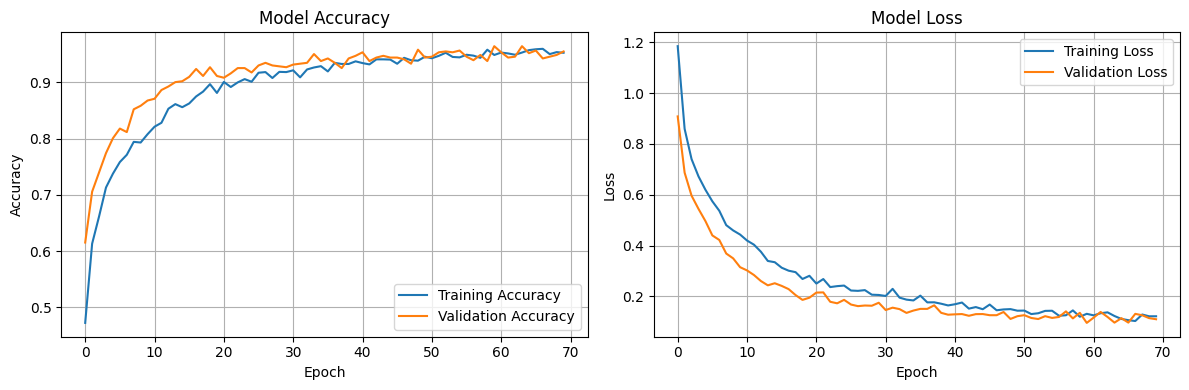

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluasi Model

In [22]:
# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Evaluasi pada training dan validation set
train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)[1]

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Test Accuracy: 0.9638
Test Loss: 0.0951
Training Accuracy: 0.9895
Validation Accuracy: 0.9642


## Prediksi

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       201
           1       0.97      0.93      0.95       202
           2       0.95      0.97      0.96       199
           3       0.97      0.98      0.98       200

    accuracy                           0.96       802
   macro avg       0.96      0.96      0.96       802
weighted avg       0.96      0.96      0.96       802



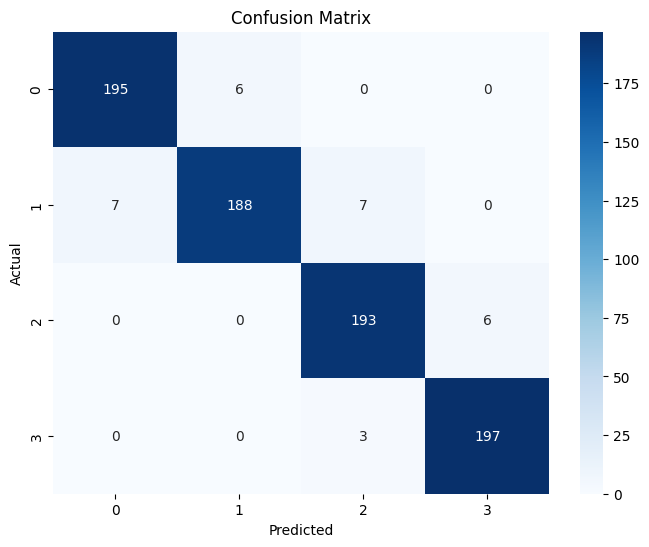

In [23]:
# Prediksi pada test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Simpan Model

In [24]:
model.save('used_car_price_model.h5')
print("Model berhasil disimpan sebagai 'used_car_price_model.h5'")

Model berhasil disimpan sebagai 'used_car_price_model.h5'


## Ringkasan

In [25]:
print("=== RINGKASAN MODEL ===")
print(f"Arsitektur: Sequential Neural Network")
print(f"Input Features: {n_features}")
print(f"Output Classes: {n_classes}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Cek apakah memenuhi syarat minimal 70%
if train_accuracy >= 0.7 and val_accuracy >= 0.7:
    print("✅ Model MEMENUHI syarat minimal akurasi 70%")
else:
    print("❌ Model TIDAK memenuhi syarat minimal akurasi 70%")
    print("Rekomendasi: Coba tuning hyperparameter atau tambah data")

=== RINGKASAN MODEL ===
Arsitektur: Sequential Neural Network
Input Features: 21
Output Classes: 4
Training Accuracy: 0.9895
Validation Accuracy: 0.9642
Test Accuracy: 0.9638
✅ Model MEMENUHI syarat minimal akurasi 70%
